Usando: cuda
Files already downloaded and verified
Files already downloaded and verified


Moviendo datos de test: 100%|███████████████████████████████| 10000/10000 [00:01<00:00, 5846.67it/s]


Número de ejemplos en entrenamiento: 45000
Número de ejemplos en test: 10000
Número de ejemplos en validación: 5000
Número de parámetros 402250
Iniciando entrenamiento con  cuda ...


epoch:: 100%|███████████████████████████████████████████████| 200/200 [01:17<00:00,  2.57it/s, loss=0.7722780108451843]



Entrenamiento completado con cuda en 77.68 segundos.

Valor de accuracy con cuda: 0.5131999850273132


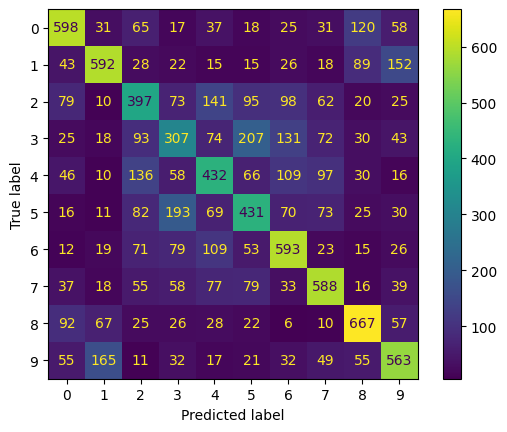

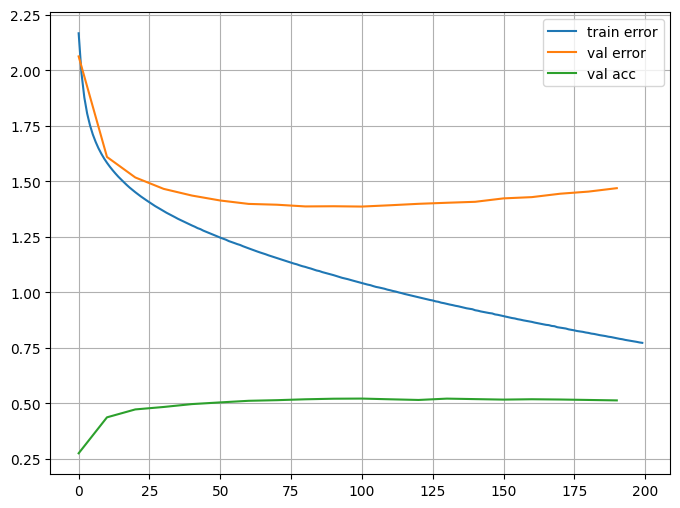

Usando: cpu
Files already downloaded and verified
Files already downloaded and verified
Número de ejemplos en entrenamiento: 45000
Número de ejemplos en test: 10000
Número de ejemplos en validación: 5000
Iniciando entrenamiento con  cpu ...


epoch:: 100%|███████████████████████████████████████████████| 200/200 [30:04<00:00,  9.02s/it, loss=0.7715036273002625]



Entrenamiento completado con cpu en 1804.26 segundos.

Valor de accuracy con cpu: 0.5192000269889832


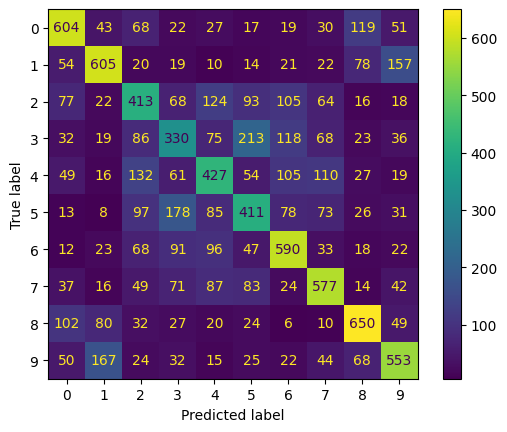

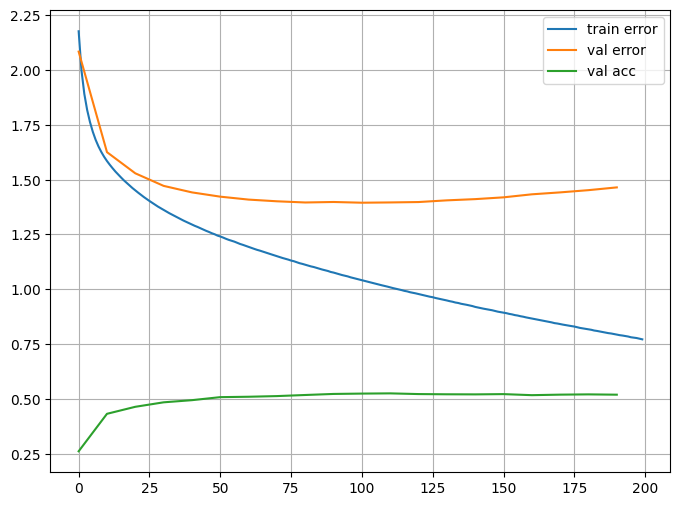

Tiempo de entrenamiento en el primer entrenamiento (cuda): 77.67602849006653
Tiempo de entrenamiento en el segundo entrenamiento(cpu): 1804.2580711841583

******* COMPARATIVA DE TIEMPO POR ÉPOCA ********
Tiempo medio por época (cuda): 0.3880 s
Tiempo medio por época (cpu): 9.0208 s
La CPU es un 2225.15% más lenta que la GPU en promedio por época.


In [11]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.nn.functional as F
import time
workpath = 'C:/Users/josea/Desktop/Universidad/Tercero/PIA/Prácticas'


usar_gpu = True
if usar_gpu:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device1 = device
else:
    device = torch.device("cpu")
    device1 = device

print(f"Usando: {device}")


def learning_loop_for_classification_with_early_stopping(train_dataloader, val_dataloader, model, epochs, loss_fn, learning_rate, optimizer, validation_freq, early_stop):
  epoch_loss_list = []
  val_loss_list = []
  val_acc_list = []
  epoch_times = []

  opt = optimizer(
    model.parameters(),
    lr=learning_rate
  )

  with tqdm(range(epochs), desc="epoch:") as pbar:
    for epoch in pbar:
      start_epoch_time = time.time()
      steps_loss_list = []
      for x_true, y_true in train_dataloader:
        #x_true = x_true.to(device)
        #y_true = y_true.to(device)
        y_pred = model(x_true)
        opt.zero_grad()
        loss = loss_fn(y_pred, y_true)
        loss.backward()
        steps_loss_list.append(loss.clone().detach())
        opt.step()
      train_loss = torch.tensor(steps_loss_list).mean()
      epoch_loss_list.append(train_loss)
      pbar.set_postfix(loss=f"{train_loss}")

      if epoch%validation_freq==0:
        val_step_loss_list = []
        val_correct_answers = 0
        val_set_size = 0
        with torch.no_grad():
          for x_val_true, y_val_true in val_dataloader:
            #x_val_true = x_val_true.to(device)
            #y_val_true = y_val_true.to(device)
            y_val_pred = model(x_val_true)
            loss_val = loss_fn(y_val_pred, y_val_true)
            val_step_loss_list.append(loss_val)
            correct_answers = torch.sum(y_val_true==torch.argmax(y_val_pred, dim=-1))
            val_correct_answers += correct_answers
            val_set_size += y_val_true.numel()
          val_loss = torch.tensor(val_step_loss_list).mean()
          val_loss_list.append(val_loss)
          val_acc_list.append(val_correct_answers/float(val_set_size))
        early_stop.check_stop(val_loss)
        if early_stop.stop:
          print("Early Stop.")
          break

      end_epoch_time = time.time()
      epoch_times.append(end_epoch_time - start_epoch_time)

  return model, epoch_loss_list, val_loss_list, val_acc_list, epoch_times


class XYDataset(Dataset):
  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, idx):
    x = self.x[idx]
    y = self.y[idx]
    return x,y

def move_dataset(dataset, device, desc="Moviendo dataset a GPU"):
    """
    Carga todo el dataset en GPU permanentemente.
    Devuelve un TensorDataset residente en GPU.
    """
    X_list, y_list = [], []
    for x, y in tqdm(dataset, desc=desc, ncols=100):
        X_list.append(x)
        y_list.append(y)
    X = torch.stack(X_list).to(device)
    y = torch.tensor(y_list, device=device)
    return XYDataset(X,y)
    
class Early_Stop():
  def __init__(self, patience=5, delta=0):
    self.patience = patience
    self.delta = delta
    self.best_val_loss = None
    self.no_val_improvement_times = 0
    self.stop = False

  def check_stop(self, val_loss):
    if self.best_val_loss is None or (val_loss + self.delta) < self.best_val_loss:
      self.best_val_loss = val_loss
      self.no_val_improvement_times = 0
    else:
      self.no_val_improvement_times += 1
      self.stop = self.no_val_improvement_times >= self.patience


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2470, 0.2435, 0.2616])
])
train_val_size = [45000, 5000]

train_dataset = datasets.CIFAR10(root=workpath, train=True, download=True, transform=transform)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, train_val_size)
test_dataset = datasets.CIFAR10(root=workpath, train=False, download=True, transform=transform)

if usar_gpu:
    train_dataset = move_dataset(train_dataset, device, desc='Moviendo datos de entrenamiento')
    val_dataset = move_dataset(val_dataset, device, desc='Moviendo datos de validación')
    test_dataset = move_dataset(test_dataset, device, desc='Moviendo datos de test')
else:
    print("Datos permanecen en CPU.")

print(f"Número de ejemplos en entrenamiento: {len(train_dataset)}")
print(f"Número de ejemplos en test: {len(test_dataset)}")
print(f"Número de ejemplos en validación: {len(val_dataset)}")


batch_size = 1024
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


learning_rate = 5e-5
epochs = 200
validation_freq = 10
delta = 1e-3
patience = 15
early_stop = Early_Stop(patience=patience, delta=delta)
optimizer = torch.optim.Adam
loss_fn = torch.nn.NLLLoss()
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(32 * 32 * 3, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 64),
    nn.LeakyReLU(),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim=1)
).to(device)

early_stop = Early_Stop(patience=patience, delta=delta)

print(f"Número de parámetros {torch.tensor([p.numel() for p in model.parameters()]).sum()}")

print(f"Iniciando entrenamiento con  {device} ...")
start_time_cpu = time.time()

model, train_loss_list, val_loss_list, val_acc_list, epoch_times_cpu = learning_loop_for_classification_with_early_stopping(
    train_dataloader,
    val_dataloader,
    model,
    epochs,
    loss_fn,
    learning_rate,
    optimizer,
    validation_freq = validation_freq,
    early_stop = early_stop)

end_time_cpu = time.time()
print(f"\nEntrenamiento completado con {device} en {end_time_cpu - start_time_cpu:.2f} segundos.")
print(f"\nValor de accuracy con {device}: {val_acc_list[-1]}")

y_pred = []
y_test = []
for val_x_true, val_y_true in test_dataloader:
  val_x_true = val_x_true.to(device)
  y_test.append(val_y_true)
  y_pred.append(model(val_x_true).detach().cpu())

y_test = torch.cat(y_test).cpu()
y_pred = torch.argmax(torch.cat(y_pred), dim=-1).cpu()

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), [loss.cpu() for loss in train_loss_list], label="train error")
plt.plot(range(0, validation_freq*len(val_loss_list), validation_freq), [loss.cpu() for loss in val_loss_list], label="val error")
plt.plot(range(0, validation_freq*len(val_acc_list), validation_freq), [acc.cpu() for acc in val_acc_list], label="val acc")
plt.legend()
plt.grid(True)
plt.show()
final_time_cpu = end_time_cpu - start_time_cpu


usar_gpu = not usar_gpu
if usar_gpu:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device2 = device
else:
    device = torch.device("cpu")
    device2 = device

print(f"Usando: {device}")

train_dataset = datasets.CIFAR10(root=workpath, train=True, download=True, transform=transform)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, train_val_size)
test_dataset = datasets.CIFAR10(root=workpath, train=False, download=True, transform=transform)

if usar_gpu:
    train_dataset = move_dataset(train_dataset, device, desc='Moviendo datos de entrenamiento')
    val_dataset = move_dataset(val_dataset, device, desc='Moviendo datos de validación')
    test_dataset = move_dataset(test_dataset, device, desc='Moviendo datos de test')

print(f"Número de ejemplos en entrenamiento: {len(train_dataset)}")
print(f"Número de ejemplos en test: {len(test_dataset)}")
print(f"Número de ejemplos en validación: {len(val_dataset)}")

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(32 * 32 * 3, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 64),
    nn.LeakyReLU(),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim=1)
).to(device)

early_stop = Early_Stop(patience=patience, delta=delta)

print(f"Iniciando entrenamiento con  {device} ...")


start_time_gpu = time.time()

model, train_loss_list, val_loss_list, val_acc_list, epoch_times_gpu = learning_loop_for_classification_with_early_stopping(
    train_dataloader,
    val_dataloader,
    model,
    epochs,
    loss_fn,
    learning_rate,
    optimizer,
    validation_freq = validation_freq,
    early_stop = early_stop)

end_time_gpu = time.time()
print(f"\nEntrenamiento completado con {device} en {end_time_gpu - start_time_gpu:.2f} segundos.")
print(f"\nValor de accuracy con {device}: {val_acc_list[-1]}")

y_pred = []
y_test = []
for val_x_true, val_y_true in test_dataloader:
  val_x_true = val_x_true.to(device)
  y_test.append(val_y_true)
  y_pred.append(model(val_x_true).detach().cpu())

y_test = torch.cat(y_test).cpu()
y_pred = torch.argmax(torch.cat(y_pred), dim=-1).cpu()

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_list)), [loss.cpu() for loss in train_loss_list], label="train error")
plt.plot(range(0, validation_freq*len(val_loss_list), validation_freq), [loss.cpu() for loss in val_loss_list], label="val error")
plt.plot(range(0, validation_freq*len(val_acc_list), validation_freq), [acc.cpu() for acc in val_acc_list], label="val acc")
plt.legend()
plt.grid(True)
plt.show()

final_time_gpu = end_time_gpu - start_time_gpu

print(f"Tiempo de entrenamiento en el primer entrenamiento ({device1}): {final_time_cpu}")
print(f"Tiempo de entrenamiento en el segundo entrenamiento({device2}): {final_time_gpu}")


mean_cpu = sum(epoch_times_cpu)/len(epoch_times_cpu)
mean_gpu = sum(epoch_times_gpu)/len(epoch_times_gpu)
speed_gain = ((mean_cpu - mean_gpu) / mean_cpu) * 100
print("\n******* COMPARATIVA DE TIEMPO POR ÉPOCA ********")
print(f"Tiempo medio por época ({device1}): {mean_cpu:.4f} s")
print(f"Tiempo medio por época ({device2}): {mean_gpu:.4f} s")
if speed_gain > 0:
    print(f"La GPU es un {speed_gain:.2f}% más rápida que la CPU en promedio por época.")
else:
    print(f"La CPU es un {-speed_gain:.2f}% más lenta que la GPU en promedio por época.")

